In [1]:
from rmp import RMPRoot, RMPTree, RMPNode, RMPLeaf_CLF
from rmp_leaf import NaiveCollisionAvoidance, CollisionAvoidance, GoalAttractorUni, Damper
from rmp_leaf import GoalAttractorUni_CLF, JointLimit_Avoidance
import numpy as np
from numpy.linalg import norm

from scipy.integrate import odeint
import matplotlib.pyplot as plt

from IPython.display import HTML
from rmp_util import obstacle, scene, policy_evaluator

# embedding matplotlib animation 
# see http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
%matplotlib inline
from matplotlib import animation, rc
rc('animation', html='html5')

# Play here

In [2]:
x_g = np.array([-2, 3])
x_o = np.array([0, 0])
x_o2 = np.array([0, 0])
x = np.array([2.5, -3.2])
x_dot = np.array([-1, 3])

test_scene = scene(goal=x_g, obstacle=[obstacle(x_o, 1)], x=x, x_dot=x_dot)

r = RMPRoot('Root')

Cave = CollisionAvoidance('collision_avoidance', r, obstacle=test_scene.obstacle[0], alpha=1e-5, eta=0)
NCave = NaiveCollisionAvoidance('naive_collision_avoidance', r, obstacle=test_scene.obstacle[0], alpha=1e-5, eta=1e-4)
Gaoi = GoalAttractorUni('goal_attractor', r, test_scene.goal)
Jave = JointLimit_Avoidance('joint_limit_avoidance', r, [-4, -4], [4, 4], sigma=0.01)
Damp = Damper('damper', r, eta=0.5)

In [3]:
tree = RMPTree(root=r, nodes=[Cave, Gaoi])
pe = policy_evaluator(test_scene, tree, np.linspace(0,100,1000), method='step')

(223, 22.322322322322325)

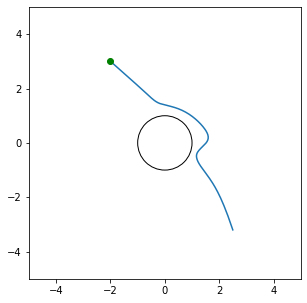

In [4]:
#print('step cost', pe.step_cost())
fig, axes = plt.subplots(figsize=(5,5))
pe.plot(fig, axes)
pe.step_cost()

In [91]:
ani1 = pe.video(fig, axes, show_path=False)
HTML(ani1.to_html5_video())
"""
if RuntimeError occours, try:
conda install -c conda-forge ffmpeg
"""

'\nif RuntimeError occours, try:\nconda install -c conda-forge ffmpeg\n'

In [92]:
ani1

In [5]:
tree.solve(np.array([1,-1]),100*np.array([-1, 1]))
np.linalg.pinv(r.M)

array([[0.99996646, 0.        ],
       [0.        , 0.99996646]])

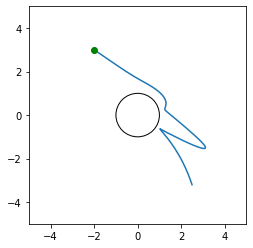

In [22]:
tree2 = RMPTree(r, [Gaoi, NCave])
pe2 = policy_evaluator(test_scene, tree2, np.linspace(0,30,300), method='step')
fig, axes = plt.subplots()
pe2.plot(fig, axes)

In [23]:
ani2 = pe2.video(fig, axes, show_path=False)
HTML(ani2.to_html5_video())

In [23]:
alpha = 1
k = 10
b = 3
def policy_candidate(x, x_dot):
    x_norm = norm(x)
    soft_uni = x_norm + (np.log(1 + np.exp(-2*alpha*x_norm))/alpha)
    return -k*(x/soft_uni) - b*x_dot

d = -10
def alpha_func(x_dot):
    return d
    #return d*np.linalg.norm(x_dot)
#def policy_candidate2(x, x_dot):
#    x_norm = (x)


In [24]:
Gaoi_CLF = GoalAttractorUni_CLF('goal_attractor_clf', r, test_scene.goal, policy_candidate, alpha_func, gain=1)
Cave = CollisionAvoidance('collision_avoidance', r, obstacle=test_scene.obstacle[0], alpha=1e-5, eta=0)

tree3 = RMPTree(root=r, nodes=[Gaoi_CLF, Cave])
pe3 = policy_evaluator(test_scene, tree3, np.linspace(0,100,1000), method='step')

(47, 4.704704704704705)


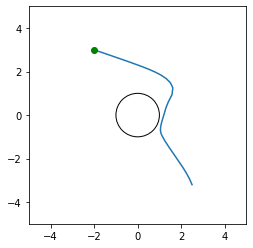

In [25]:
fig, axes = plt.subplots()
pe3.plot(fig, axes)
print(pe3.step_cost())

In [26]:
Gaoi_CLF.V_dot

[array([[-2.70938084]]),
 array([[-0.62217011]]),
 array([[-0.16175961]]),
 array([[0.60075719]]),
 array([[1.1641356]]),
 array([[1.88250551]]),
 array([[2.68933015]]),
 array([[3.77925955]]),
 array([[4.84995663]]),
 array([[6.35889084]]),
 array([[7.57000969]]),
 array([[9.29269825]]),
 array([[10.00000001]]),
 array([[10.00000005]]),
 array([[10.00000005]]),
 array([[10.00000004]]),
 array([[10.00000003]]),
 array([[10.00000001]]),
 array([[10.]]),
 array([[9.99999847]]),
 array([[9.99999829]]),
 array([[9.99999989]]),
 array([[10.00000004]]),
 array([[10.00000003]]),
 array([[9.99999749]]),
 array([[9.99997673]]),
 array([[9.99994989]]),
 array([[8.90580138]]),
 array([[8.4769984]]),
 array([[7.32164426]]),
 array([[6.95290162]]),
 array([[5.89105009]]),
 array([[5.38908528]]),
 array([[4.15513706]]),
 array([[3.04642286]]),
 array([[0.87255303]]),
 array([[-0.38653038]]),
 array([[-2.68708273]]),
 array([[-3.79750326]]),
 array([[-6.52397212]]),
 array([[-8.95537777]]),
 array([[

In [15]:
ani3 = pe3.video(fig, axes, show_path=False)
HTML(ani3.to_html5_video())

# Notes
- the robot may be struggled under the summation dynamics


### Matplot Lab

In [ ]:
fig, axes = plt.subplots(figsize=(10,10))

x = np.linspace(0, 2*np.pi, 100)
axes.plot(x, np.sin(x))
circle = plt.Circle((np.pi, 0), 0.5)
axes.add_artist(circle)
axes.set_aspect('equal')


In [ ]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('grade3')

# Test relative RMP tree
1. **pushforward** to propagate states to all notes
2. **pullback** the Cave RMP to root (individually)
3. 